## 13-9. 프로젝트 : 주식 예측에 도전해 보자

## STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
# [[YOUR CODE]]
dataset_filepath = os.getenv("HOME") + '/aiffel/stock_prediction/data/GOOG.csv' # 구글
df = pd.read_csv(dataset_filepath, index_col="Date", parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,49.813290,51.835709,47.800831,49.982655,49.982655,44871361
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942874
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342897
2004-08-24,55.412300,55.591629,51.591621,52.239197,52.239197,15319808
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232276


In [2]:
ts = df['Close']
ts.head()

Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239197
2004-08-25    52.802086
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [3]:
# 결측치 처리
# [[YOUR CODE]]

# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다.
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


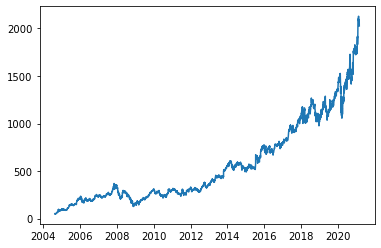

In [4]:
# 보간 이후 결측치 유무 다시 확인
print(ts[ts.isna()])

# 다시 그래프 확인
plt.plot(ts)

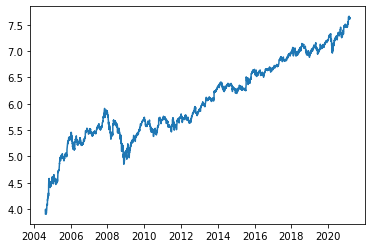

In [5]:
# 로그 변환
# [[YOUR CODE]]
ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='b', label='Original')
    mean = plt.plot(rolmean, color='r', label='Rolling Mean')
    std = plt.plot(rolstd, color='k', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('ok')

ok


In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag="AIC")
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test: ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('ok')

ok


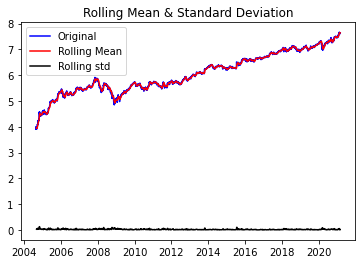

Results of Dickey-Fuller Test: 
Test Statistic                   -1.895851
p-value                           0.334016
#Lags Used                        7.000000
Number of Observations Used    4155.000000
Critical Value (1%)              -3.431925
Critical Value (5%)              -2.862236
Critical Value (10%)             -2.567140
dtype: float64


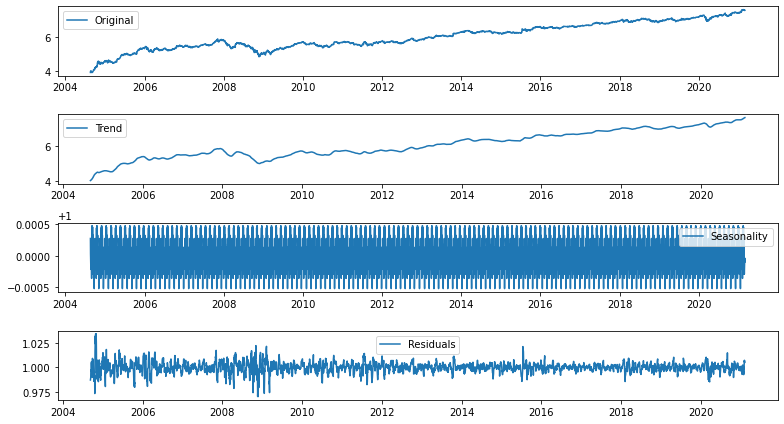

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### 시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 1에 가깝게 나타났습니다. 이것이 바로 이 귀무가설이 옳다는 직접적인 증거가 되지는 않지만, 적어도 이 귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없습니다.

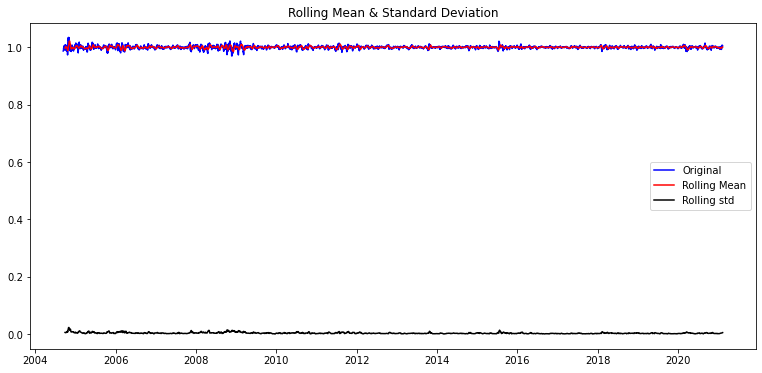

In [9]:
# Residual 안정성 확인
# [[YOUR CODE]]
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [10]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test: 
Test Statistic                -1.490784e+01
p-value                        1.473715e-27
#Lags Used                     3.000000e+01
Number of Observations Used    4.102000e+03
Critical Value (1%)           -3.431945e+00
Critical Value (5%)           -2.862245e+00
Critical Value (10%)          -2.567145e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

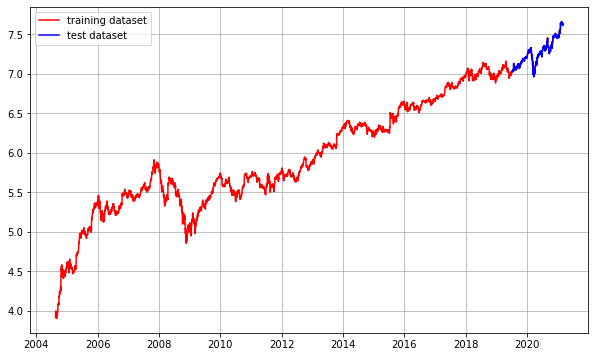

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [12]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2004-08-19    3.911676
2004-08-20    3.988109
Name: Close, dtype: float64
(3746,)
(417,)


## STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

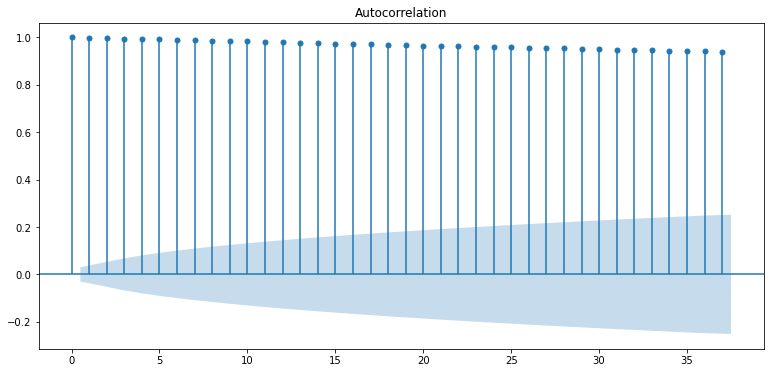

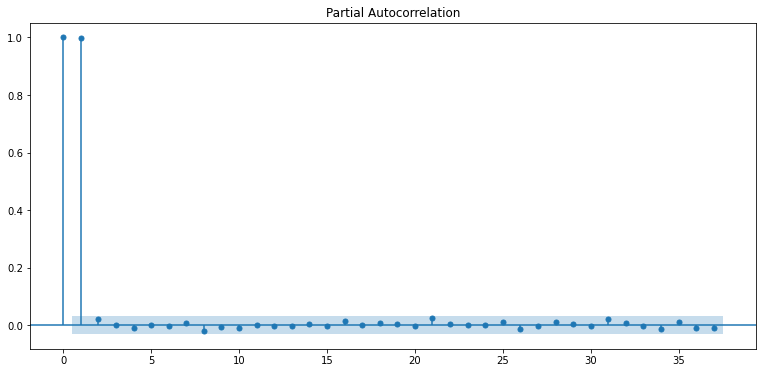

In [13]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test: 
Test Statistic                  -24.620477
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    4155.000000
Critical Value (1%)              -3.431925
Critical Value (5%)              -2.862236
Critical Value (10%)             -2.567140
dtype: float64


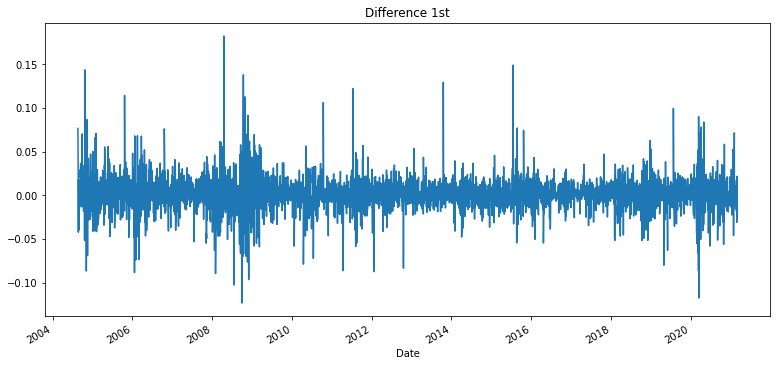

In [14]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test: 
Test Statistic                  -20.532330
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4129.000000
Critical Value (1%)              -3.431935
Critical Value (5%)              -2.862240
Critical Value (10%)             -2.567143
dtype: float64


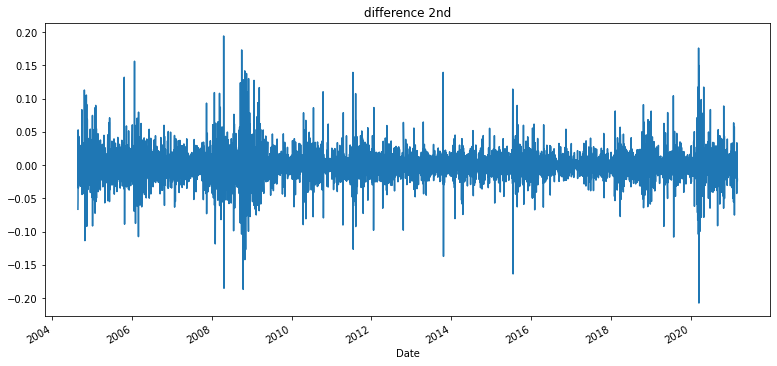

In [15]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title="difference 2nd")

augmented_dickey_fuller_test(diff_2)

어떤 게 안정적인 상태이지..?

## STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [16]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# [[YOUR CODE]]
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3745
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9551.347
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 04 Mar 2021   AIC                         -19096.693
Time:                        13:09:32   BIC                         -19078.009
Sample:                             1   HQIC                        -19090.048
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.659      0.008       0.000       0.001
ar.L1.D.Close     0.0107      0.016      0.655      0.512      -0.021       0.043
                                    Root

/home/aiffel-dj47/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj47/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

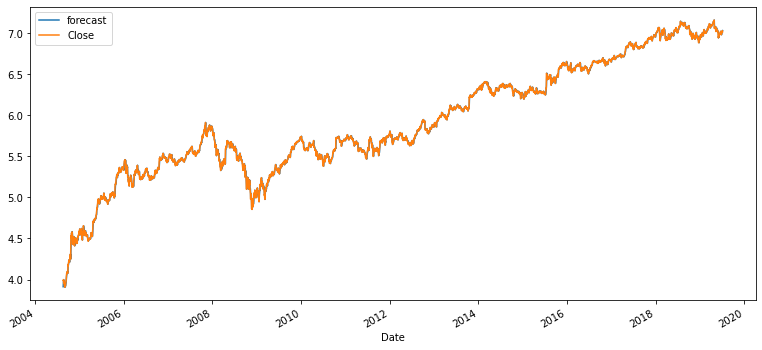

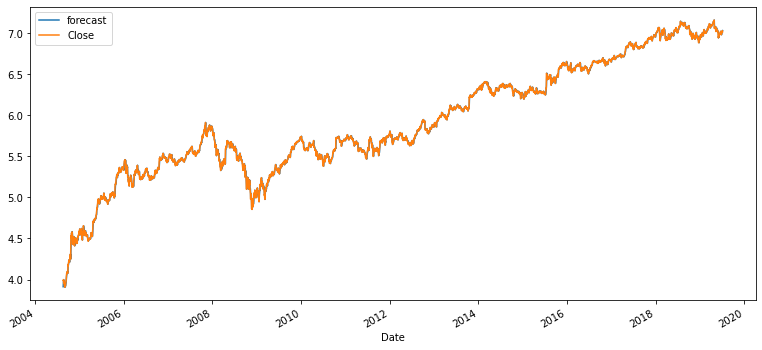

In [17]:
# 훈련 데이터에 대해 ARMIMA 모델이 잘 fit한느지 시각적으로 확인
fitted_m.plot_predict()

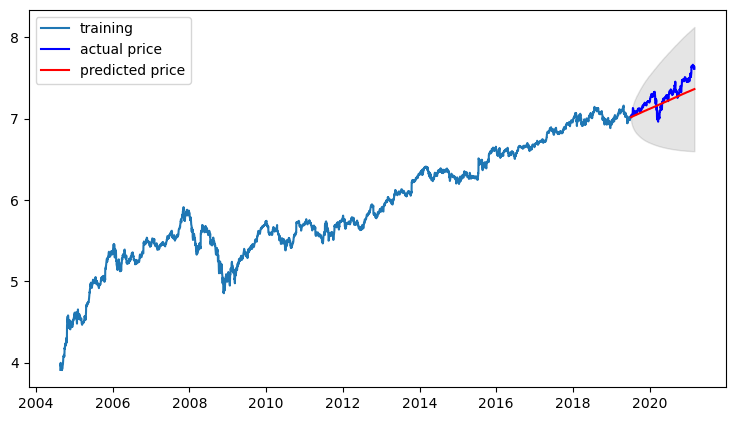

In [18]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
# [[YOUR CODE]]
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  34945.02445736144
MAE:  143.21450555772506
RMSE:  186.93588327916456
MAPE: 9.10%


#### MAPE 9.1% 확인

## STEP 7 : 다른 주식 종목 예측해 보기
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

## STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
# [[YOUR CODE]]
dataset_filepath = os.getenv("HOME") + '/aiffel/stock_prediction/data/207940.KS.csv' # 삼성바이오로직스
df = pd.read_csv(dataset_filepath, index_col="Date", parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-11,149500.0,186500.0,142000.0,161500.0,161500.0,8140539.0
2016-11-14,165000.0,177500.0,165000.0,175500.0,175500.0,2977177.0
2016-11-15,179000.0,181500.0,162500.0,166000.0,166000.0,2592949.0
2016-11-16,168500.0,173000.0,163500.0,170000.0,170000.0,1660976.0
2016-11-17,176500.0,177500.0,167500.0,167500.0,167500.0,912260.0


In [21]:
ts = df['Close']
ts.head()

Date
2016-11-11    161500.0
2016-11-14    175500.0
2016-11-15    166000.0
2016-11-16    170000.0
2016-11-17    167500.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [22]:
# 결측치 처리
# [[YOUR CODE]]

# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다.
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


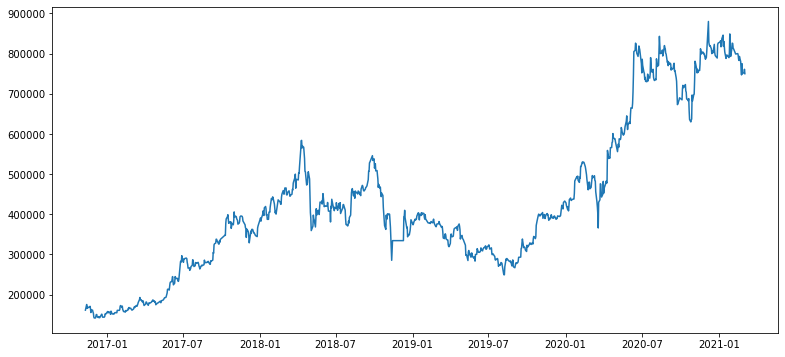

In [23]:
# 보간 이후 결측치 유무 다시 확인
print(ts[ts.isna()])

# 다시 그래프 확인
plt.plot(ts)

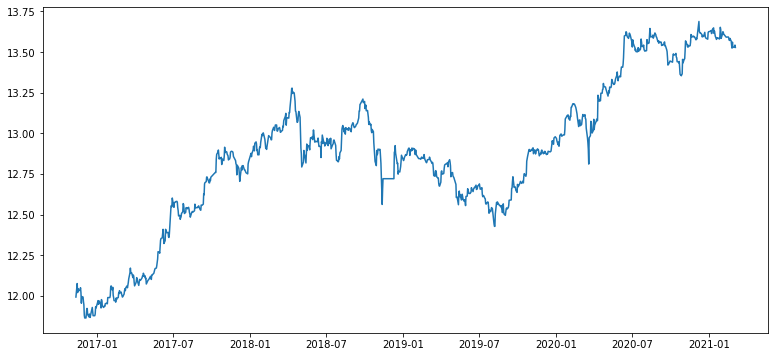

In [24]:
# 로그 변환
# [[YOUR CODE]]
ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [25]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='b', label='Original')
    mean = plt.plot(rolmean, color='r', label='Rolling Mean')
    std = plt.plot(rolstd, color='k', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('ok')

ok


In [26]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag="AIC")
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test: ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('ok')

ok


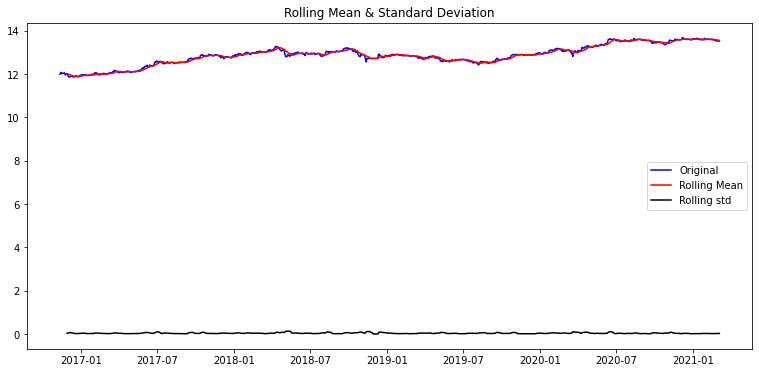

Results of Dickey-Fuller Test: 
Test Statistic                   -1.419283
p-value                           0.572998
#Lags Used                        0.000000
Number of Observations Used    1054.000000
Critical Value (1%)              -3.436569
Critical Value (5%)              -2.864286
Critical Value (10%)             -2.568232
dtype: float64


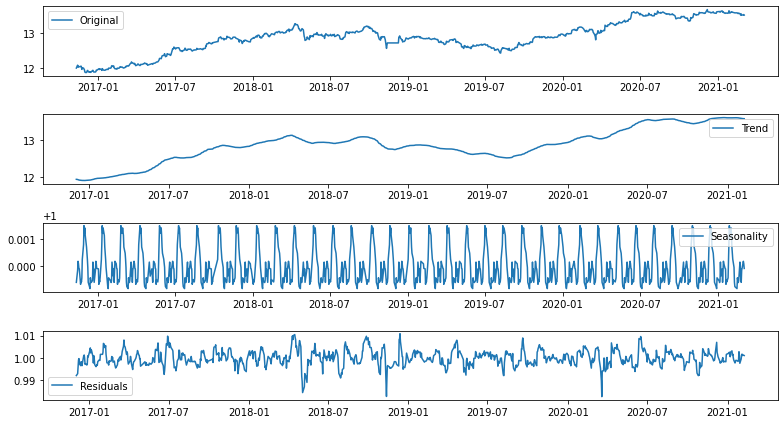

In [27]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

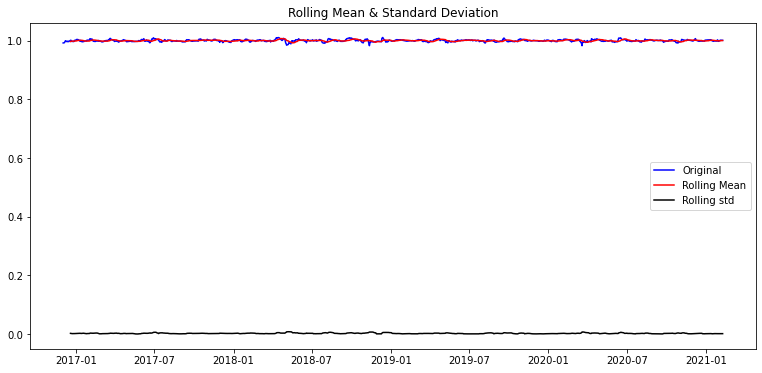

In [28]:
# Residual 안정성 확인
# [[YOUR CODE]]
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [29]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test: 
Test Statistic                -1.058985e+01
p-value                        6.570805e-19
#Lags Used                     1.100000e+01
Number of Observations Used    1.013000e+03
Critical Value (1%)           -3.436822e+00
Critical Value (5%)           -2.864397e+00
Critical Value (10%)          -2.568291e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

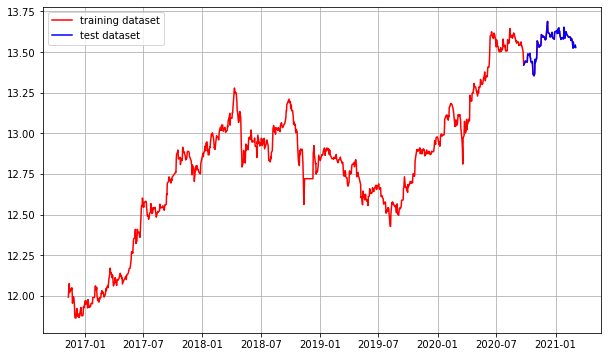

In [30]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [31]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2016-11-11    11.992260
2016-11-14    12.075394
Name: Close, dtype: float64
(949,)
(106,)


## STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

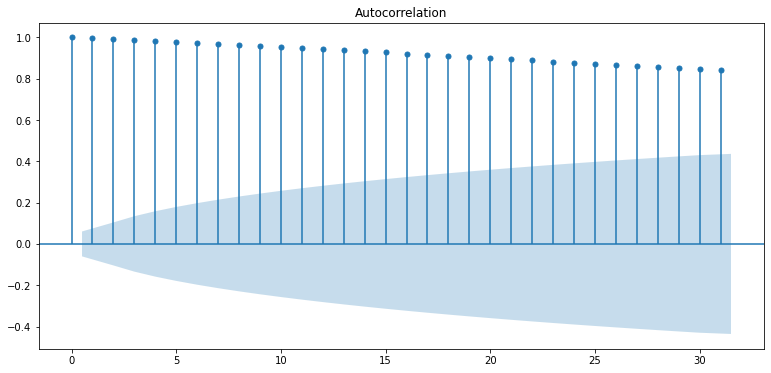

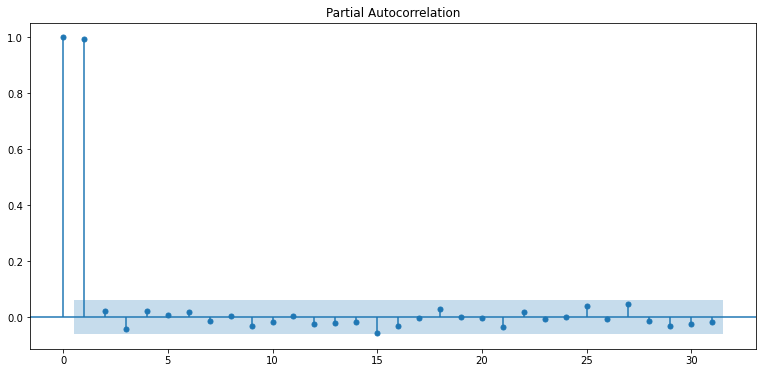

In [32]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test: 
Test Statistic                  -31.906595
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1053.000000
Critical Value (1%)              -3.436575
Critical Value (5%)              -2.864289
Critical Value (10%)             -2.568234
dtype: float64


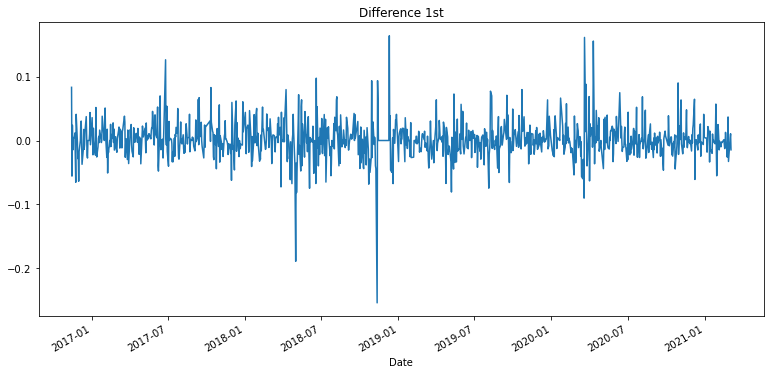

In [33]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test: 
Test Statistic                -1.304132e+01
p-value                        2.238053e-24
#Lags Used                     1.800000e+01
Number of Observations Used    1.034000e+03
Critical Value (1%)           -3.436690e+00
Critical Value (5%)           -2.864339e+00
Critical Value (10%)          -2.568260e+00
dtype: float64


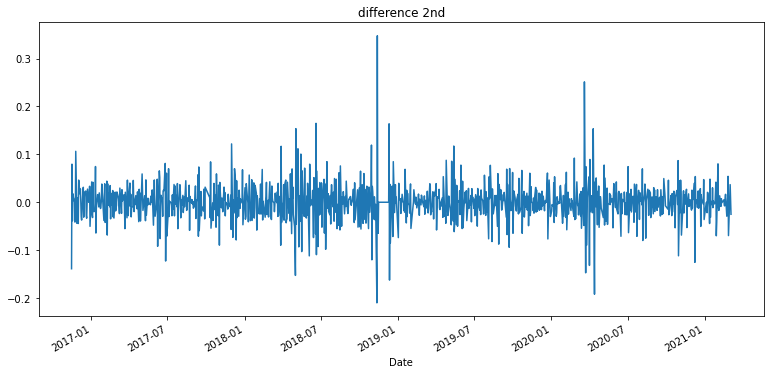

In [34]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title="difference 2nd")

augmented_dickey_fuller_test(diff_2)

어떤 게 안정적인 상태이지..?

## STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [35]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# [[YOUR CODE]]
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  948
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1992.892
Method:                       css-mle   S.D. of innovations              0.030
Date:                Thu, 04 Mar 2021   AIC                          -3979.784
Time:                        13:09:35   BIC                          -3965.221
Sample:                             1   HQIC                         -3974.234
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.001      1.587      0.113      -0.000       0.003
ar.L1.D.Close     0.0206      0.033      0.631      0.528      -0.043       0.085
                                    Root

/home/aiffel-dj47/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj47/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

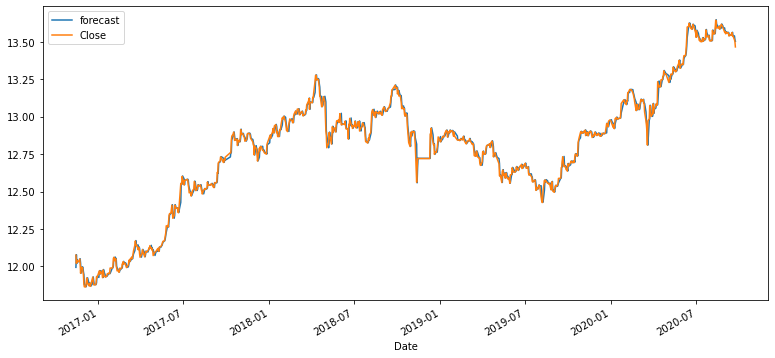

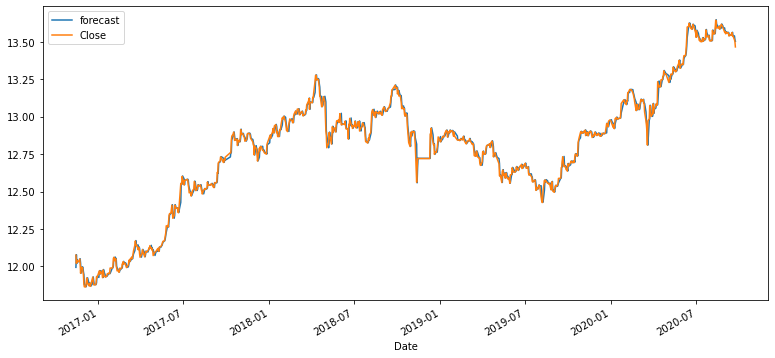

In [36]:
# 훈련 데이터에 대해 ARMIMA 모델이 잘 fit한느지 시각적으로 확인
fitted_m.plot_predict()

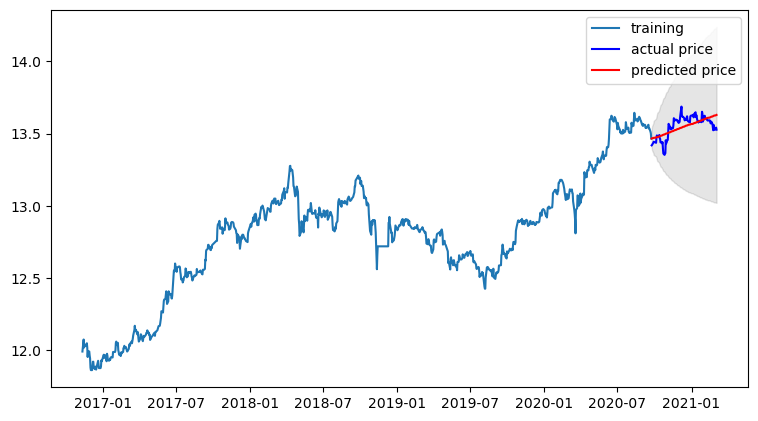

In [37]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
# [[YOUR CODE]]
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1876402761.279363
MAE:  35640.92812571735
RMSE:  43317.46485286694
MAPE: 4.67%


## STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
# [[YOUR CODE]]
dataset_filepath = os.getenv("HOME") + '/aiffel/stock_prediction/data/BABA.csv' # 알리바바
df = pd.read_csv(dataset_filepath, index_col="Date", parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-19,92.699997,99.699997,89.949997,93.889999,93.889999,271879400
2014-09-22,92.699997,92.949997,89.500000,89.889999,89.889999,66657800
2014-09-23,88.940002,90.480003,86.620003,87.169998,87.169998,39009800
2014-09-24,88.470001,90.570000,87.220001,90.570000,90.570000,32088000
2014-09-25,91.089996,91.500000,88.500000,88.919998,88.919998,28598000


In [40]:
ts = df['Close']
ts.head()

Date
2014-09-19    93.889999
2014-09-22    89.889999
2014-09-23    87.169998
2014-09-24    90.570000
2014-09-25    88.919998
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [41]:
# 결측치 처리
# [[YOUR CODE]]

# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다.
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


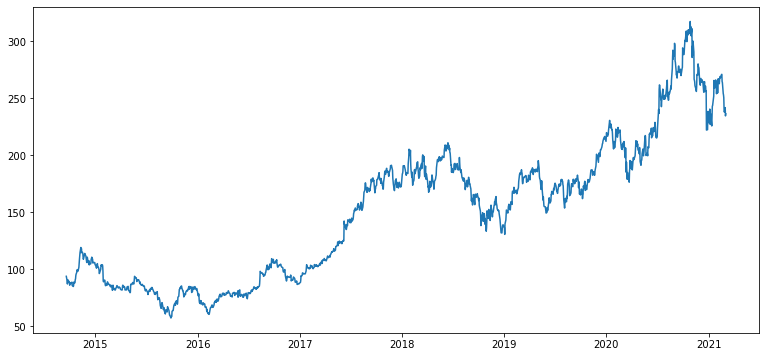

In [42]:
# 보간 이후 결측치 유무 다시 확인
print(ts[ts.isna()])

# 다시 그래프 확인
plt.plot(ts)

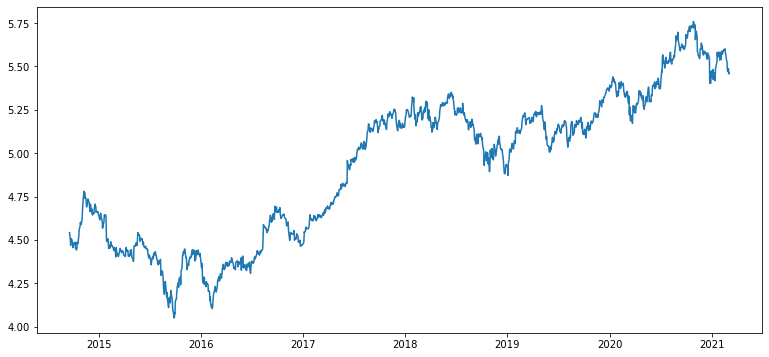

In [43]:
# 로그 변환
# [[YOUR CODE]]
ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [44]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='b', label='Original')
    mean = plt.plot(rolmean, color='r', label='Rolling Mean')
    std = plt.plot(rolstd, color='k', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('ok')

ok


In [45]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag="AIC")
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test: ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('ok')

ok


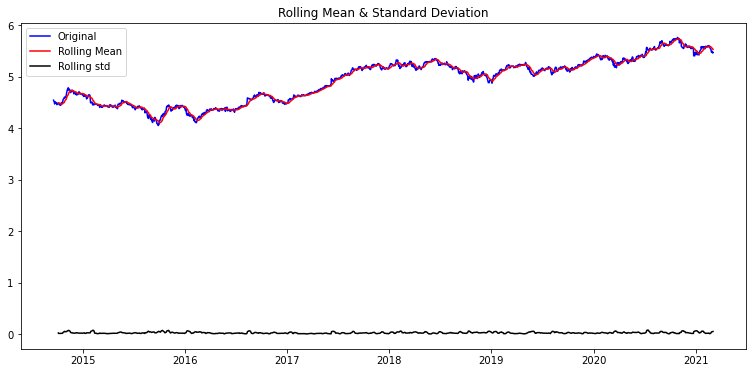

Results of Dickey-Fuller Test: 
Test Statistic                   -0.850840
p-value                           0.803730
#Lags Used                        8.000000
Number of Observations Used    1615.000000
Critical Value (1%)              -3.434406
Critical Value (5%)              -2.863331
Critical Value (10%)             -2.567724
dtype: float64


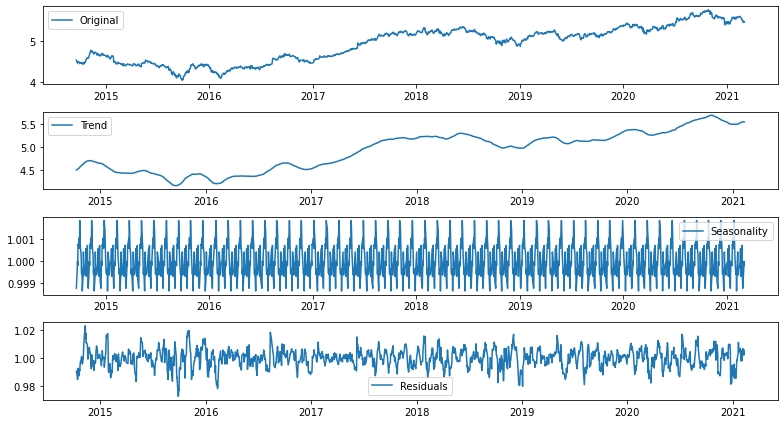

In [46]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

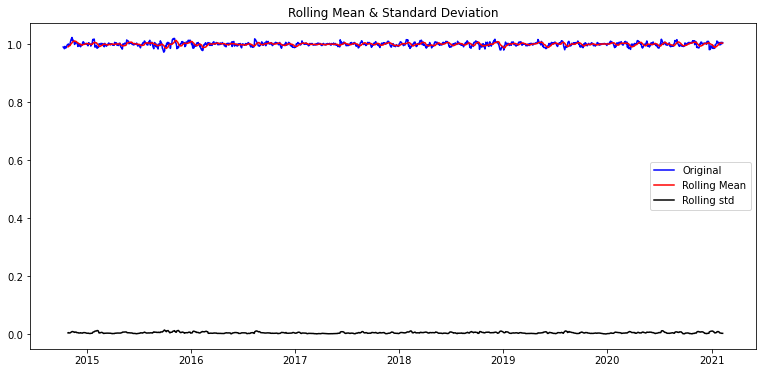

In [47]:
# Residual 안정성 확인
# [[YOUR CODE]]
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [48]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test: 
Test Statistic                -1.117379e+01
p-value                        2.601046e-20
#Lags Used                     2.400000e+01
Number of Observations Used    1.569000e+03
Critical Value (1%)           -3.434525e+00
Critical Value (5%)           -2.863384e+00
Critical Value (10%)          -2.567752e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

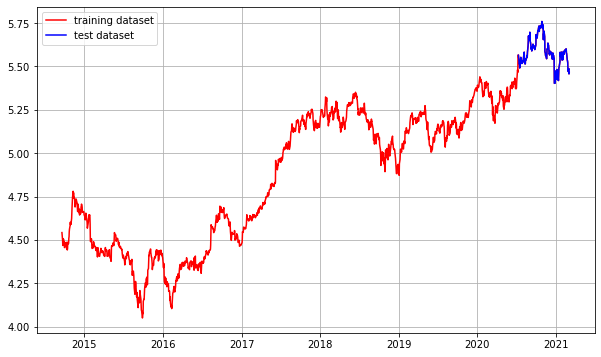

In [49]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [50]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2014-09-19    4.542124
2014-09-22    4.498587
Name: Close, dtype: float64
(1461,)
(163,)


## STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

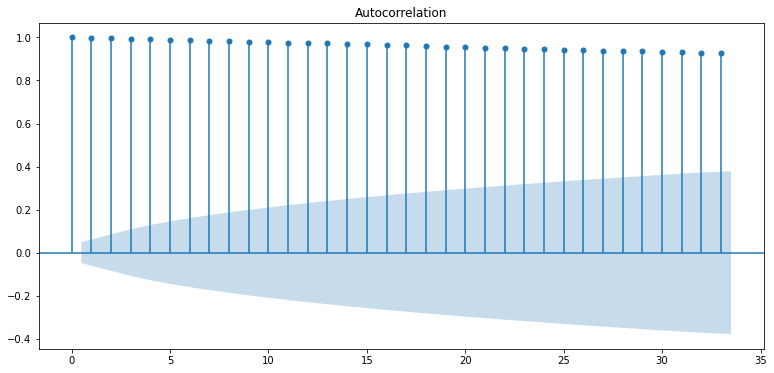

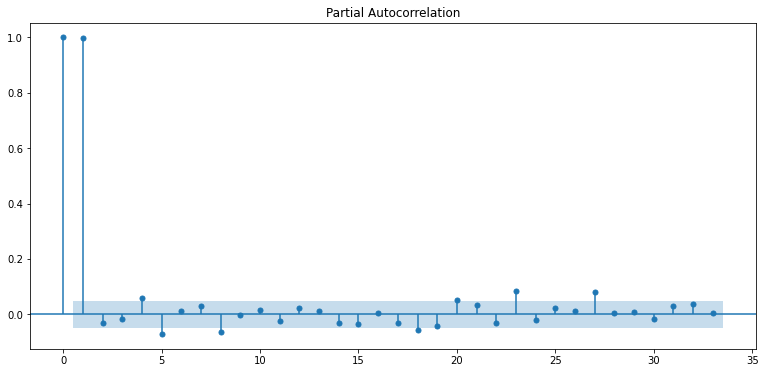

In [51]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

pacf그래프에서 볼 때 p는 1이 적합해 보임 q는 없어 보임..?

Results of Dickey-Fuller Test: 
Test Statistic                -1.468440e+01
p-value                        3.119597e-27
#Lags Used                     7.000000e+00
Number of Observations Used    1.615000e+03
Critical Value (1%)           -3.434406e+00
Critical Value (5%)           -2.863331e+00
Critical Value (10%)          -2.567724e+00
dtype: float64


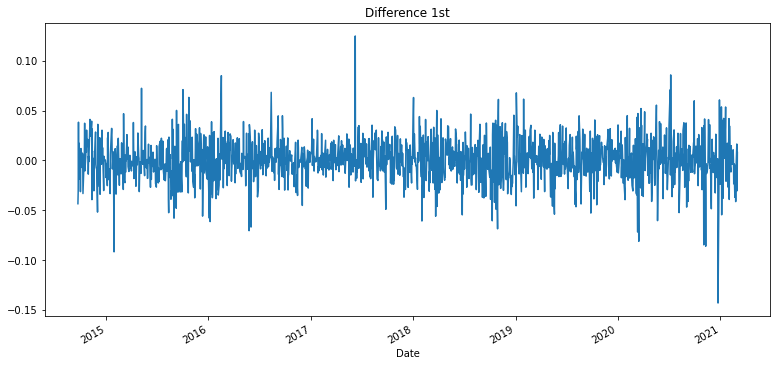

In [52]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test: 
Test Statistic                -1.881845e+01
p-value                        2.022240e-30
#Lags Used                     1.600000e+01
Number of Observations Used    1.605000e+03
Critical Value (1%)           -3.434431e+00
Critical Value (5%)           -2.863342e+00
Critical Value (10%)          -2.567730e+00
dtype: float64


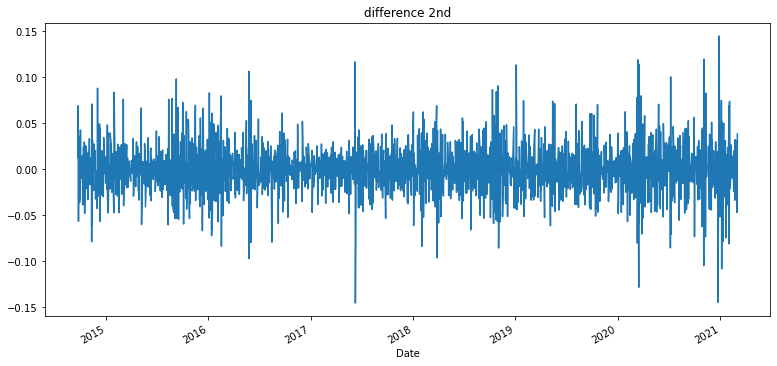

In [53]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title="difference 2nd")

augmented_dickey_fuller_test(diff_2)

어떤 게 안정적인 상태이지..?

## STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [54]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# [[YOUR CODE]]
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1460
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3595.502
Method:                       css-mle   S.D. of innovations              0.021
Date:                Thu, 04 Mar 2021   AIC                          -7185.004
Time:                        13:09:38   BIC                          -7169.146
Sample:                             1   HQIC                         -7179.088
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.001      1.253      0.210      -0.000       0.002
ar.L1.D.Close     0.0359      0.026      1.370      0.171      -0.015       0.087
                                    Root

/home/aiffel-dj47/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj47/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

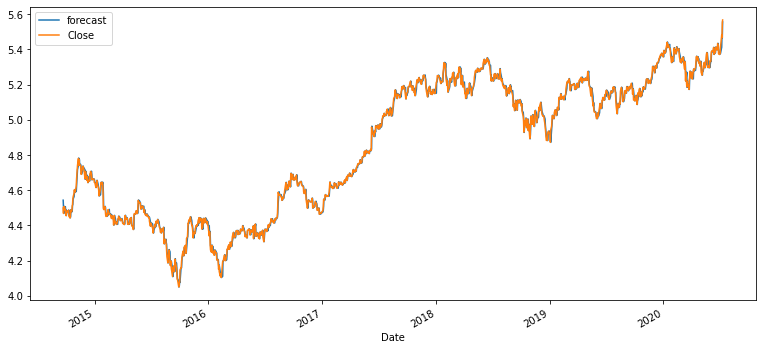

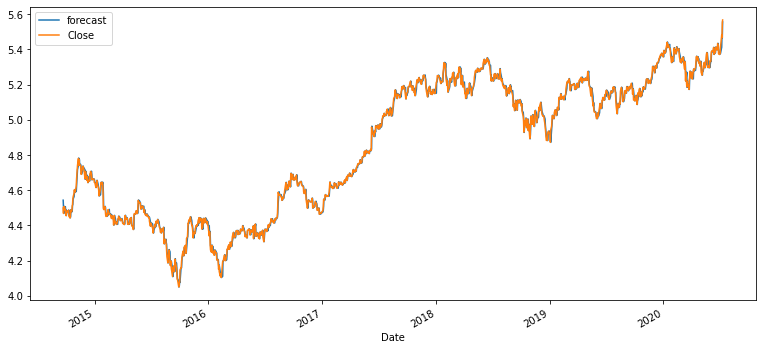

In [55]:
# 훈련 데이터에 대해 ARMIMA 모델이 잘 fit한느지 시각적으로 확인
fitted_m.plot_predict()

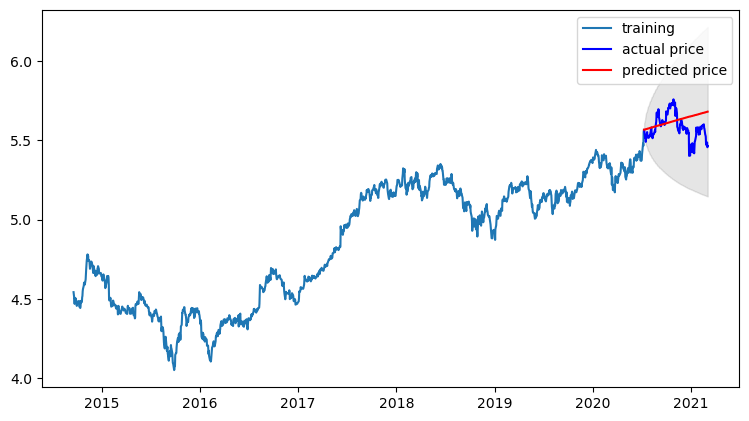

In [56]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
# [[YOUR CODE]]
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  734.959478912166
MAE:  22.33622295249529
RMSE:  27.11013609173082
MAPE: 8.59%


# MAPE 10% 이하
**google 9.1  
삼성바이오로직스 4.67  
alibaba 8.59**


# 그 외 시도해본 기업
amazon 21.65  
신풍제약 42.55  
tesla 43.97  
facebook 23.37  
삼성전자우 20.45  
네이버 25.10  
카카오 44.95  
셀트리온 28.08  
lg화학 27.72  
삼성sdi 26.65  
강원랜드 33.52  
삼성생명 24.75  
nike 오류  
NVDIA 27.17
walmart 오류  
등등


# 총평

제출하는 아이파이썬 외에도 다른 아이파이썬에서 13-9 방법 외에도 13-3~13-8까지 참고하여 이것저것 시도해 봤지만 오류만 발생하고 더 나아지진 않았다. 오류가 발생해 노드에 있는대로 진행했다. 수학적 지식이 부족해서 그런지 이해 못하는 내용이 많았고 표를 보고도 내용을 잘 이해를 못했다.  
여러 기업을 넣어봐서 MAPE를 기준 이하로 나오게 했다. 한 가지 발견한 것은 nike, walmart와 같이 1970~80년대부터 있던 기업을 넣으면 -값이 발생해  진행이 안되는 것을 알았다. 그래서 비교적 역사가 짧은 기업을 해보니 좋은 값을 얻을 수 있었다.